# GHP Construction with Duration matching

As we saw in the previous lab, we can easily match a liability if we had a zero coupon bond that had the exact maturity as the liability, in which case, assuming we had enough funds available, we could do perfect cash flow matching.

In this lab, we'll use a portfolio of standard, non-coupon bonds to try and achieve the same behaviour as a zero coupon bond.

In order to do this, we'll have to find a way to price a bond, but as it turns out, we've already written the code to do this. Recall that we implemented the code to compute the present value of a sequence of liability cash flows. Well, a bond is nothing more than a series of cash flows that the issuer is offering to make to you, and therefore, the price of a bond is nothing more than the present value of the future cash flows.

To be more precise, we should use discount rates matching the payment horizons using the yield curve. For simplicity, we'll assume that the yield curve is flat, and the rate of interest is the same regardless of whether it is 1 year, 5 year, 10 year or 30 year horizon. We'll also assume that bonds pay a monthly coupon thereby avoiding some of the complexities of intra-coupon payment. 

Add the following code:

```python
import math
def bond_cash_flows(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12):
    """
    Returns the series of cash flows generated by a bond,
    indexed by the payment/coupon number
    maturity is the no of years after the zc bond matures
    """
    n_coupons = round(maturity*coupons_per_year)
    coupon_amt = principal*coupon_rate/coupons_per_year
    coupon_times = np.arange(1, n_coupons+1)
    cash_flows = pd.Series(data=coupon_amt, index=coupon_times)
    cash_flows.iloc[-1] += principal # add the principal to the last payment
    return cash_flows
    
def bond_price(maturity, principal=100, coupon_rate=0.03, coupons_per_year=12, discount_rate=0.03):
    """
    Computes the price of a bond that pays regular coupons until maturity
    at which time the principal and the final coupon is returned
    This is not designed to be efficient, rather,
    it is to illustrate the underlying principle behind bond pricing!
    """
    cash_flows = bond_cash_flows(maturity, principal, coupon_rate, coupons_per_year)
    return pv(cash_flows, discount_rate/coupons_per_year)
```


In [1]:
import numpy as np
import pandas as pd
import edhec_risk_kit_126 as erk
%matplotlib inline
%load_ext autoreload
%autoreload 2

C:\Users\User\Desktop\Coursera\Introduction_to_portfolio_construction\Codes\notebooks_and_codem01_v02\nb\edhec_risk_kit_126.py:36: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if filetype is "returns":
C:\Users\User\Desktop\Coursera\Introduction_to_portfolio_construction\Codes\notebooks_and_codem01_v02\nb\edhec_risk_kit_126.py:39: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif filetype is "nfirms":
C:\Users\User\Desktop\Coursera\Introduction_to_portfolio_construction\Codes\notebooks_and_codem01_v02\nb\edhec_risk_kit_126.py:42: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif filetype is "size":


In [2]:
erk.bond_price(20, 1000, 0.05, 2, .04)

1136.7773962036904

## Bond prices change with interest rates

Consider the following chart that shows the change in value of a bond for interest rates from 2% to 10%. The bond in question is a 10 year bond that pays a 5% coupon semiannually and the face value is $1000.

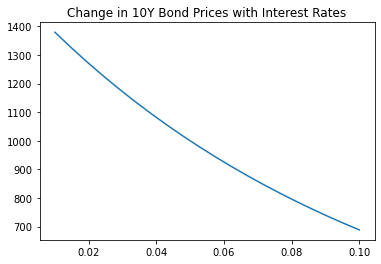

In [3]:
rates = np.linspace(.01, .10, num=20)
prices = [erk.bond_price(10, 1000, 0.05, 2, rate) for rate in rates]
pd.DataFrame(data=prices, index=rates).plot(title="Change in 10Y Bond Prices with Interest Rates", legend=False)

Assume that we have a liability of \$1000 in 10 years. Clearly, we cannot use this as a hedge, since we would be severely underfunded if interest rates rise, and over funded if they fall. If we had a Zero Coupon bond, we could purchase that, but Zero Coupon bonds of specific maturities arent always available.

What is available are various bonds with maturities from 5 to 30 years. How do we build a portfolio that has the same sensitivity to interest rates as our liabilities do? If they both respond the same way to changes in interest rates, we can effectively obtain immunity to interest rate changes.

One way to do this is through _Duration Matching_. The duration of a bond measures its senstivity to interest rate changes. Therefore, we match the duration of the liabilities to the duration of the bond portfolio. As it happens, the duration of a bond which is computed as the weighted average time of the cash flows, weighted by the cash flows.

Thus the duration of a Zero Coupon bond is just the maturity, since there is a single cash flow at maturity.

In [4]:
cf = erk.bond_cash_flows(3, 1000, .06, 2)
cf

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [5]:
discounts = erk.discount(cf.index, .06/2)
discounts

Float64Index([ 0.970873786407767, 0.9425959091337544, 0.9151416593531595,
              0.8884870479156888, 0.8626087843841639, 0.8374842566836542],
             dtype='float64')

In [6]:
dcf = (discounts*cf)
dcf

1     29.126214
2     28.277877
3     27.454250
4     26.654611
5     25.878264
6    862.608784
dtype: float64

In [7]:
(cf.index*dcf).sum()/dcf.sum()

5.5797071871945345

This is the Macaulay Duration which is the weighted average number of periods you have to be invested in the bond to get the present value of the bond back. In this example, we'll need to wait about 5.58/2 = 2.79 years on average to get back the present value of the bond. You can also compute something called the _Modified Duration_ which gives you a more direct measure of how much the bond price will move for a small change in interest rates (i.e. the first derivative of the bond price with respect to interest rates). However, we won't need to compute that since the Macaulay Duration is itself a measure of sensitivity and all we need to do is to match that to our liability.

Let's add the following code to our toolkit:

```python
def macaulay_duration(flows, discount_rate):
    """
    Computes the Macaulay Duration of a sequence of cash flows, given a per-period discount rate
    """
    discounted_flows = discount(flows.index, discount_rate)*flows
    weights = discounted_flows/discounted_flows.sum()
    return np.average(flows.index, weights=weights)
```


In [6]:
erk.bond_cash_flows(3, 1000, .06, 2)

1      30.0
2      30.0
3      30.0
4      30.0
5      30.0
6    1030.0
dtype: float64

In [8]:
erk.macaulay_duration(erk.bond_cash_flows(3, 1000, .06, 2), 0.06/2)

5.579707187194534

# Duration Matching

Assume we have a liability of \\$100 K in 10 years time and another of \\$100K in 12 years time. Assume interest rates are 4%. What is the duration of the liabilities?


In [7]:
liabilities = pd.Series(data = [100000, 100000], index=[10, 12])
erk.macaulay_duration(liabilities, .04)

10.960799385088393

Now assume we have two types of bonds available. We have a 10 year bond and a 15 year bond. Each of them pays a 5% coupon once a year and has a face value of \\$1000. What are the durations of these bonds?

In [8]:
md_10 = erk.macaulay_duration(erk.bond_cash_flows(10, 1000, .05, 1), .04)
md_10

8.190898824083233

In [9]:
md_20 = erk.macaulay_duration(erk.bond_cash_flows(20, 1000, .05, 1), .04)
md_20

13.544718122145921

Therefore, we need to hold a portfolio of these two bonds that has a combined target duration that matches the duration of the liability, which is given by the following expression, where $w_s$ is the weight in the short duration bond whcih has duration $d_s$ and the duration of the longer bond is $d_l$. We designate the targeted duration as $d_t$.

In our case, the fraction in the short duration asset $w_s$ should be such that:

$$ w_s \times 8.19 + (1-w_s) \times 13.54 = 10.96 $$

more generally:

$$ w_s \times d_s + (1-w_s) \times d_l = d_t $$

rearranging gives:

$$ w_s = \frac{d_l -d_t}{d_l - d_s} $$

```python
def match_durations(cf_t, cf_s, cf_l, discount_rate):
    """
    Returns the weight W in cf_s that, along with (1-W) in cf_l will have an effective
    duration that matches cf_t
    """
    d_t = macaulay_duration(cf_t, discount_rate)
    d_s = macaulay_duration(cf_s, discount_rate)
    d_l = macaulay_duration(cf_l, discount_rate)
    return (d_l - d_t)/(d_l - d_s)
```

While we are at it, let's update the funding ratio we developed the last time to support cash flows in the assets:

```python
def funding_ratio(assets, liabilities, r):
    """
    Computes the funding ratio of a series of liabilities, based on an interest rate and current value of assets
    """
    return pv(assets, r)/pv(liabilities, r)
```


In [10]:
short_bond = erk.bond_cash_flows(10, 1000, .05, 1)
long_bond = erk.bond_cash_flows(20, 1000, .05, 1)
w_s = erk.match_durations(liabilities, short_bond, long_bond, 0.04)
w_s

0.48263092069478974

In [14]:
p_short = erk.bond_price(10, 1000, .05, 1, 0.04)
p_long = erk.bond_price(20, 1000, .05, 1, 0.04)
a_0 = 130000
dm_assets=pd.concat([a_0*w_s*short_bond/p_short,a_0*(1-w_s)*long_bond/p_long])
erk.macaulay_duration(dm_assets, 0.04)

10.960799385088393

In [17]:
dm_assets

1      2901.743586
2      2901.743586
3      2901.743586
4      2901.743586
5      2901.743586
6      2901.743586
7      2901.743586
8      2901.743586
9      2901.743586
10    60936.615315
1      2960.550536
2      2960.550536
3      2960.550536
4      2960.550536
5      2960.550536
6      2960.550536
7      2960.550536
8      2960.550536
9      2960.550536
10     2960.550536
11     2960.550536
12     2960.550536
13     2960.550536
14     2960.550536
15     2960.550536
16     2960.550536
17     2960.550536
18     2960.550536
19     2960.550536
20    62171.561257
dtype: float64

In [14]:
erk.macaulay_duration(liabilities, 0.04)

10.960799385088393

In [15]:
cfr = erk.funding_ratio(dm_assets, liabilities, 0.04)
cfr

0.9998760012192478

In [23]:
erk.pv(liabilities,0.04) 

130016.12184058638

In [16]:
lb_assets = a_0*long_bond/p_long
erk.funding_ratio(lb_assets, liabilities, 0.04)

0.9998760012192477

In [17]:
sb_assets = a_0*short_bond/p_short
erk.funding_ratio(sb_assets, liabilities, 0.04)

0.9998760012192477

In [18]:
erk.funding_ratio(lb_assets, liabilities, 0.03)-cfr

0.027467589831998485

In [19]:
erk.funding_ratio(lb_assets, liabilities, 0.05)-cfr

-0.02232913141503523

In [20]:
erk.funding_ratio(sb_assets, liabilities, 0.03)-cfr

-0.026067215268698818

In [21]:
erk.funding_ratio(sb_assets, liabilities, 0.05)-cfr

0.02721629283763294

In [22]:
erk.funding_ratio(dm_assets, liabilities, 0.03)-cfr

0.0016300375570328374

In [23]:
erk.funding_ratio(dm_assets, liabilities, 0.05)-cfr

0.001583022308244031

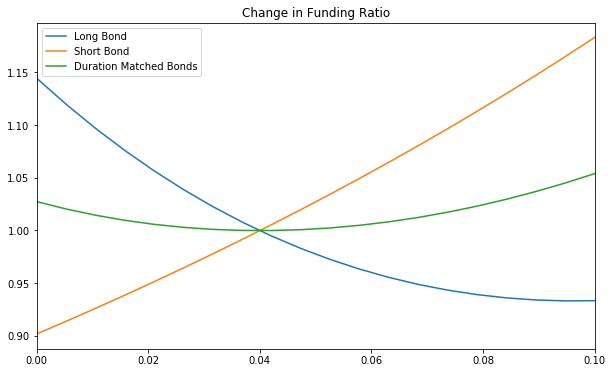

In [24]:
rates = np.linspace(0, .1, 20)
fr_change = pd.DataFrame({
    "Long Bond":[erk.funding_ratio(lb_assets, liabilities, r) for r in rates],
    "Short Bond":[erk.funding_ratio(sb_assets, liabilities, r) for r in rates],
    "Duration Matched Bonds":[erk.funding_ratio(dm_assets, liabilities, r) for r in rates]
}, index=rates)
fr_change.plot(title='Change in Funding Ratio', figsize=(10,6))

## Conclusion

We've seen that if you have the assets on hand, you can secure future liabilities by matching the duration of your liabilities with the durations of your assets to immunize yourself against level shifts in the yield curve. In practice, you might also want to protect against changes in the slope and curvature of the yield curve by using convexity hedging, but duration hedging is a simple but essential step towards ensuring that you will have the money to meet your liabilities when interest rates fluctuate.
